In [ ]:

import cv2
import imagehash
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image
#from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

In [ ]:
# Data augmentation for training
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [ ]:
size_images = 150
batch_size = 32

In [ ]:
train_path = 'seg_train'
test_path = 'seg_test'

In [ ]:
# Create a generator for training data
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 14034 images belonging to 6 classes.


In [ ]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [ ]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [ ]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

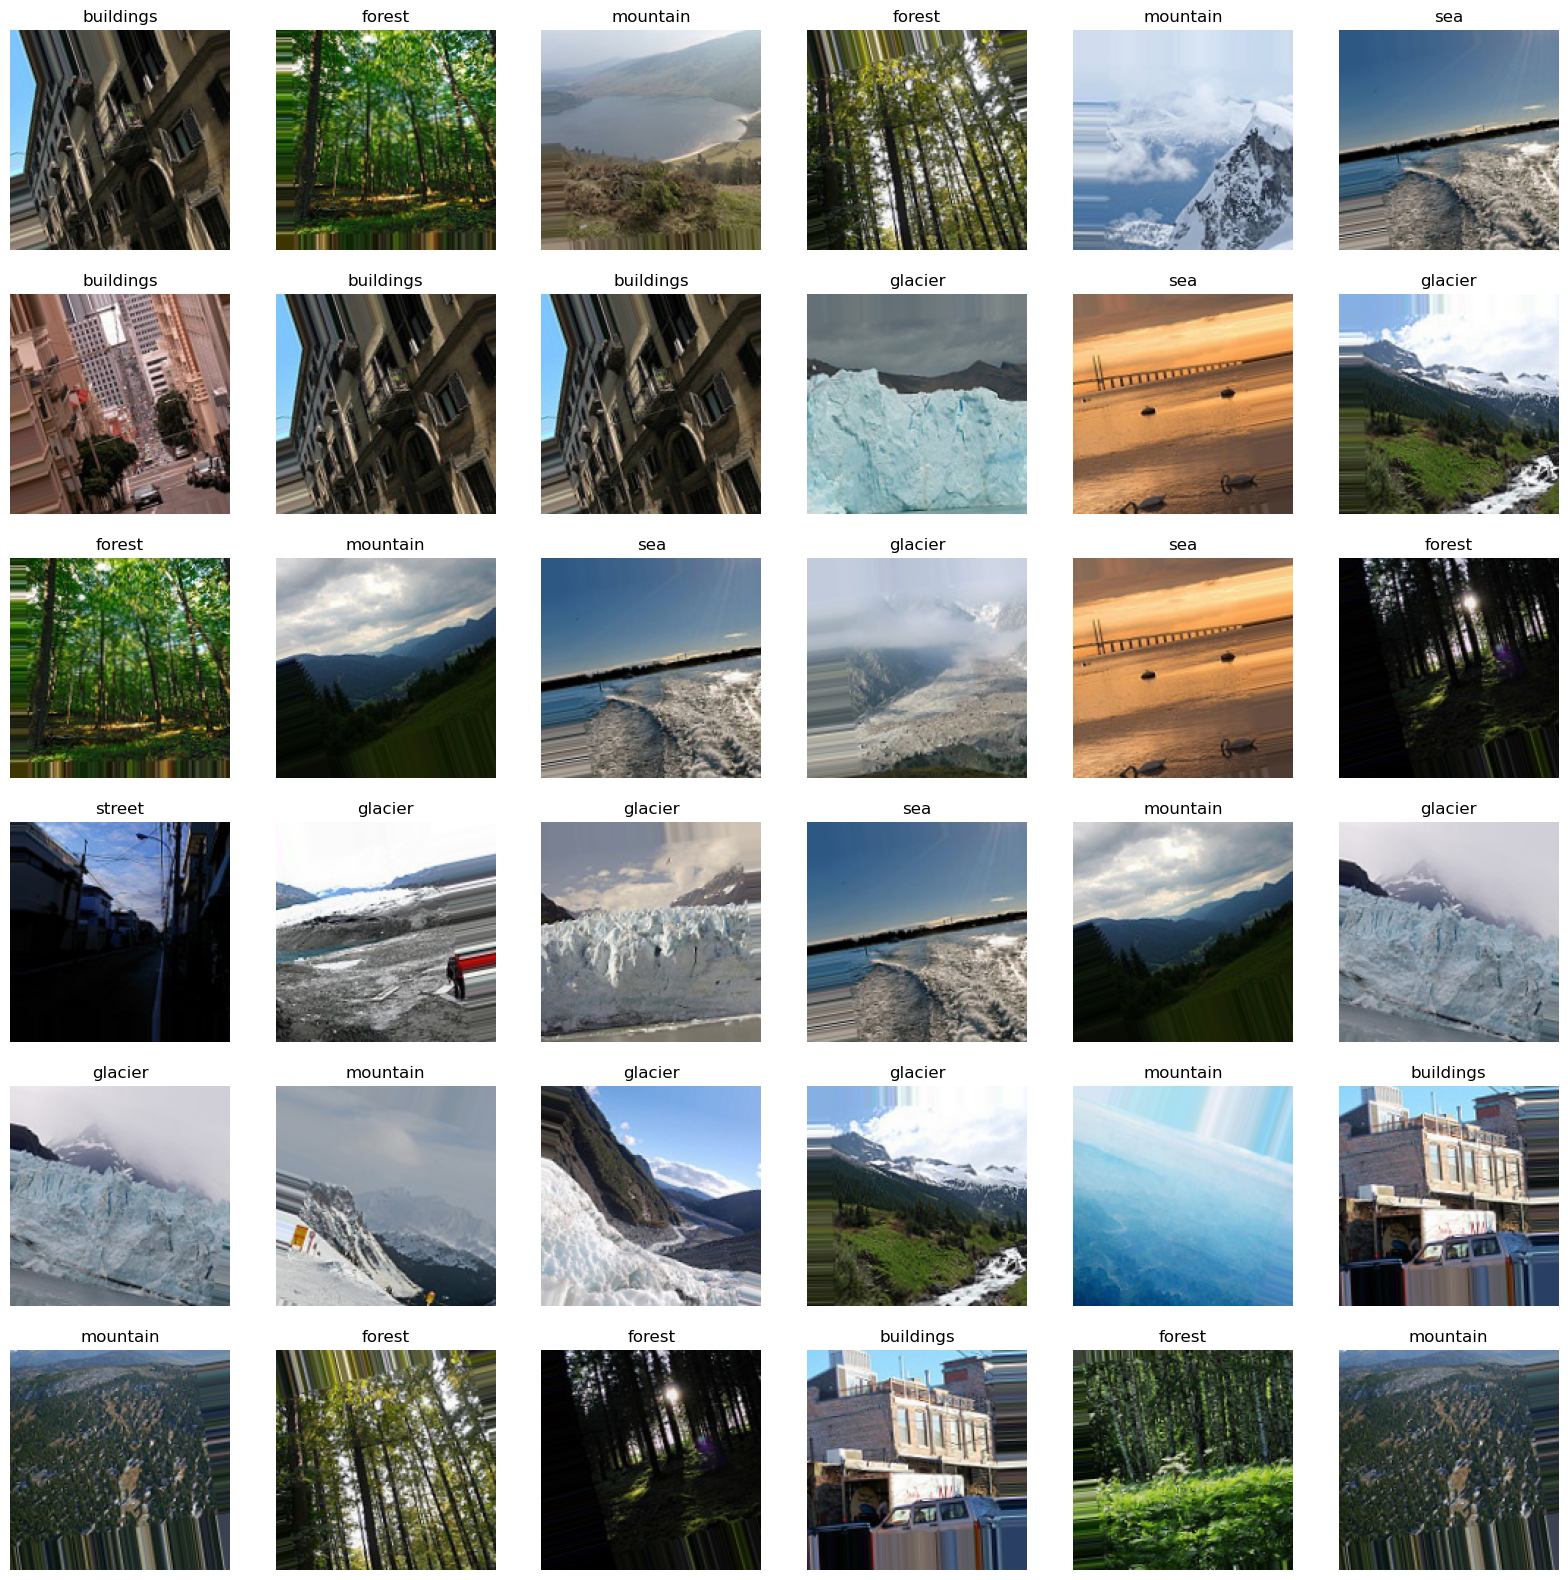

In [ ]:
Show_Images(train_generator)

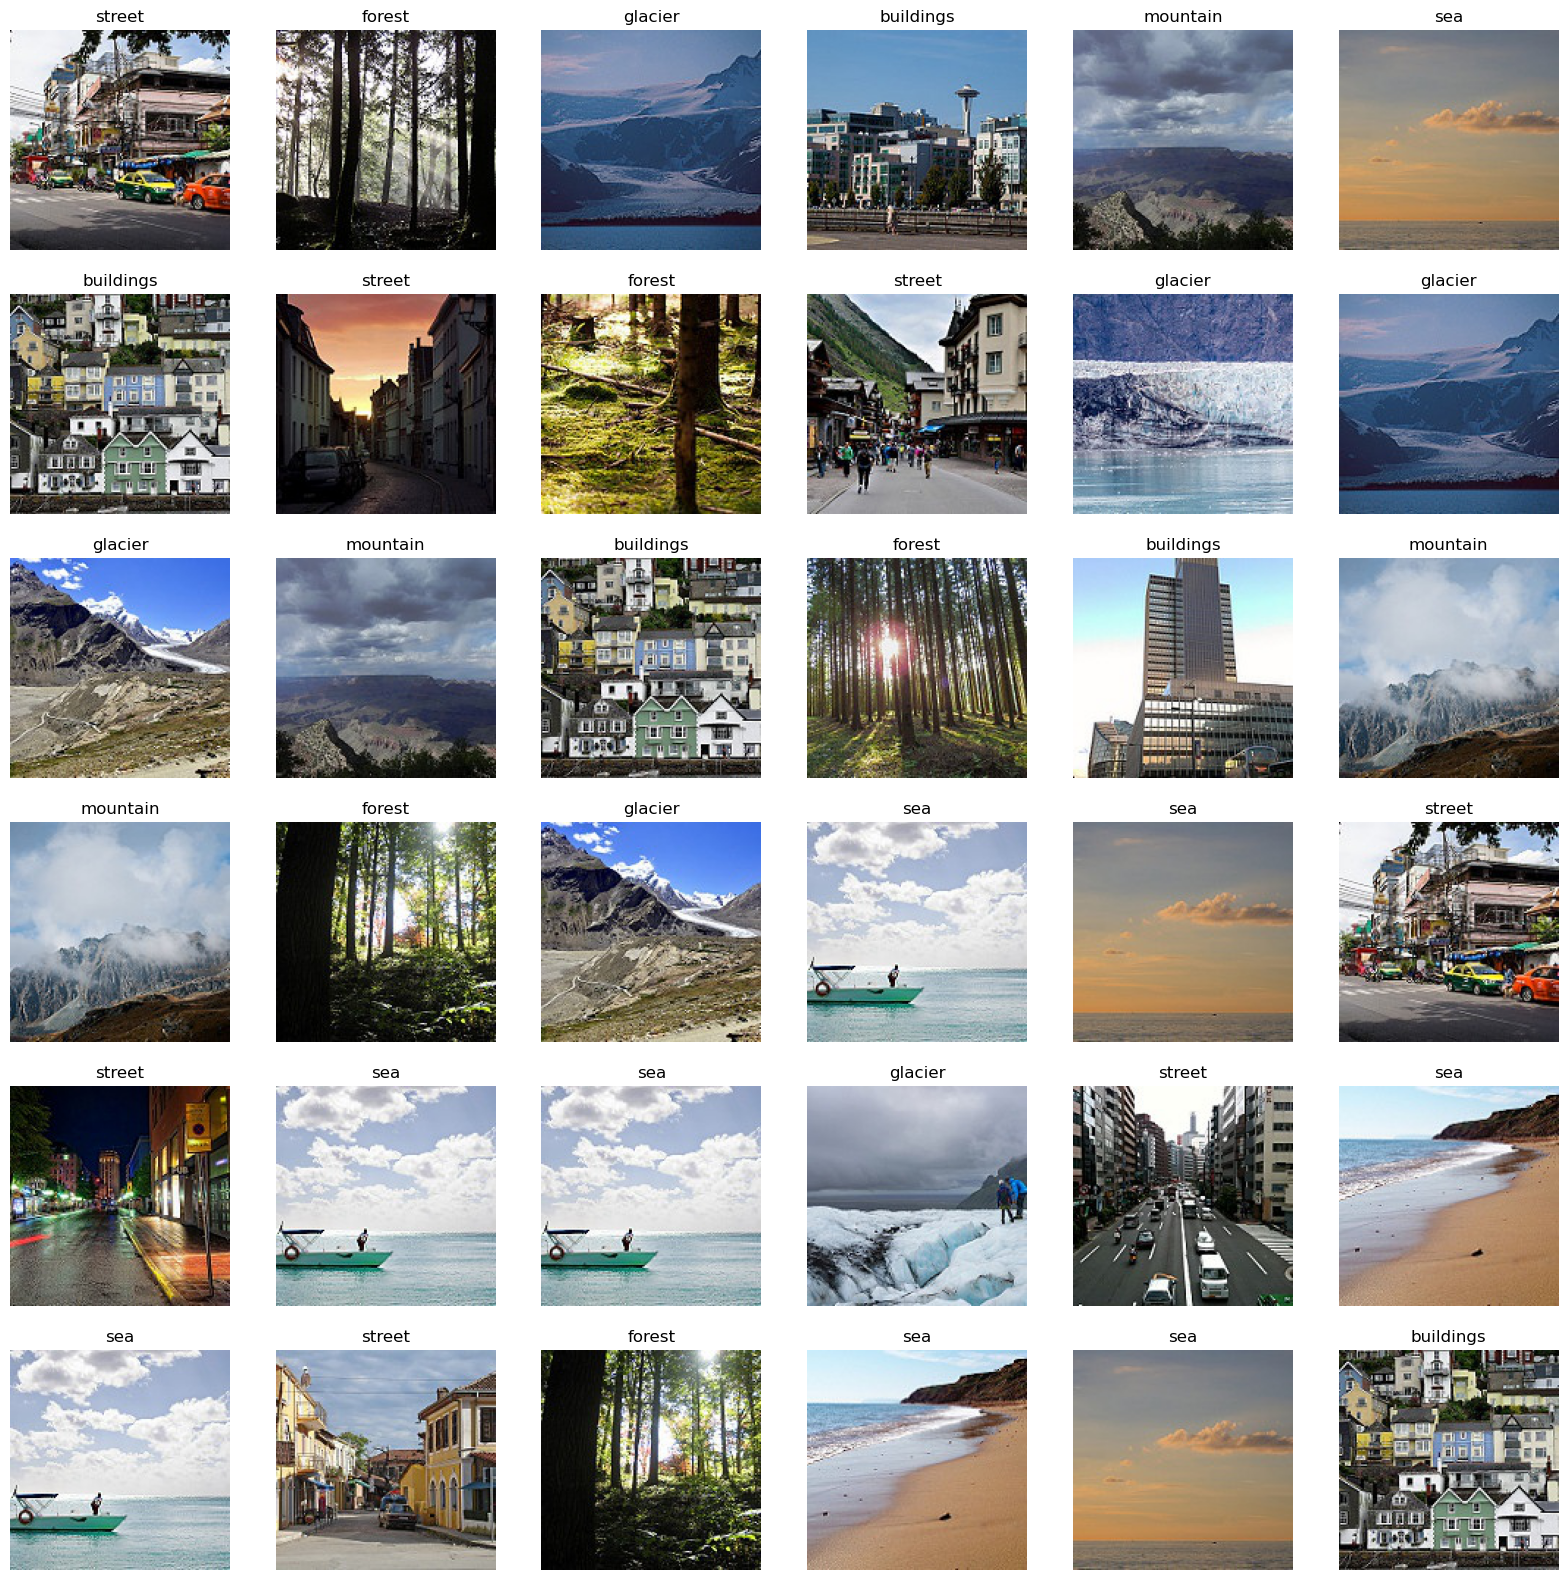

In [ ]:
Show_Images(test_generator)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Rest of your code
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=5,       # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
from tensorflow.keras.applications import VGG16

# Rest of your code
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Rest of your code
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [ ]:
# Define the parameters for the exponential decay schedule
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [ ]:
from keras.callbacks import LearningRateScheduler


lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [ ]:
from tensorflow.compat.v1 import train

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'val_accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/20


438/438 [==============================] - 636s 1s/step - loss: 0.7856 - accuracy: 0.7023 - val_loss: 0.4114 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 2/20
150/438 [=========>....................] - ETA: 5:45 - loss: 0.5726 - accuracy: 0.7919

In [ ]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])